In [1]:
# Script to generate a simulated raingage datafile

import pandas as pd
from io import StringIO

# Sample cumulative rainfall input (time in hours, depth in mm)
sample_data = """# Time Depth
0.0 0.00
3.9 1.20
7.0 2.40
10.0 3.00
11.0 3.00
"""

# Read into DataFrame
df = pd.read_csv(StringIO(sample_data), comment="#", sep=r"\s+", names=["time_hr", "depth_mm"])

# Convert time (hours) to datetime starting from a defined origin
origin = pd.Timestamp("2025-01-01 00:00:00")
df["timestamp"] = origin + pd.to_timedelta(df["time_hr"], unit="h")

# Reorder columns for clarity
df = df[["timestamp", "time_hr", "depth_mm"]]

# Save to external CSV file
output_filename = "generated_rainfall_data.csv"
df.to_csv(output_filename, index=False)

print(f"✅ File saved: {output_filename}")

✅ File saved: generated_rainfall_data.csv


In [2]:
# Script to generate 1-minute hyetographs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
hyetType = 'type2'
PT = 1.0 # total depth
#######################################
hour = [0,2,4,6,7,8,8.5,9,9.5,9.75,10,10.5,11,11.5,11.75,12,12.5,13.0,13.6,14,16,20,24,24.25]
minutes = [i*60 for i in hour]
hyets = {
        'type1': [0,0.035,0.076,0.125,0.156,0.194,0.219,0.254,0.303,0.362,0.515,0.583,0.624,0.654,0.669,0.682,0.706,0.727,0.748,0.767,0.83,0.926,1,1],
        'type1A': [0,0.05,0.116,0.206,0.268,0.425,0.48,0.52,0.55,0.564,0.577,0.601,0.624,0.645,0.655,0.664,0.683,0.701,0.719,0.736,0.8,0.906,1,1],
        'type2': [0,0.022,0.048,0.08,0.098,0.12,0.133,0.147,0.163,0.172,0.181,0.204,0.235,0.283,0.357,0.663,0.735,0.772,0.799,0.82,0.88,0.952,1,1],
        'type3': [0,0.02,0.043,0.072,0.089,0.115,0.13,0.148,0.167,0.178,0.189,0.216,0.25,0.298,0.339,0.5,0.702,0.751,0.785,0.811,0.886,0.957,1,1],
        'user': [0,0,0.4285,0.8571,1.0,1.0,1.0,1.0]  # Adjust time scaling below if needed
    }
if hyetType == 'user':
    user_time = [0,7,8,9,9.3333,10,24,48]
    minutes = [i*60 for i in user_time]
    hyet = hyets['user']
else:
    hyet = hyets.get(hyetType)
f = interp1d(minutes, hyet, kind='linear')
t24 = np.arange(0, 1455)  # 48 hours in minutes
depth = PT * f(t24)  # Scaled cumulative rainfall depth
intensity = np.diff(np.insert(depth, 0, 0)) * 60  # in/hr
# Build DataFrame ########################################
df = pd.DataFrame({
    "Time (min)": t24,
    "Cumulative Depth (in)": depth,
    "Intensity (in/hr)": intensity
})
# Optionally, write every nth row (e.g., every 15 minutes)
n = 30
df_thinned = df.iloc[::n]
# Save to CSV ##########################################################
df_thinned.to_csv(f"interpolated_output_{hyetType.upper()}.csv", index=False)
##########################################################################

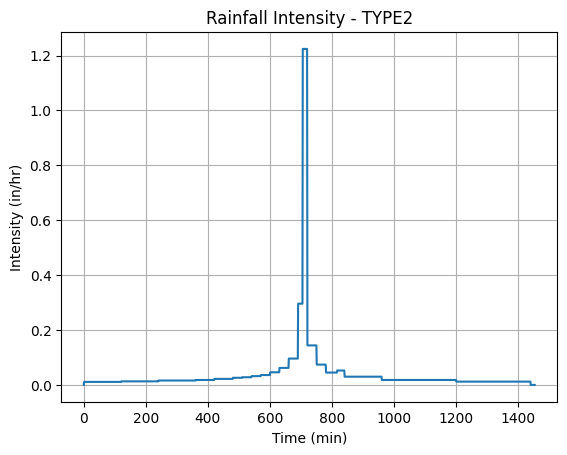

In [3]:
# Optional plot (for visual inspection)
plt.plot(t24, intensity)
plt.title(f"Rainfall Intensity - {hyetType.upper()}")
plt.xlabel("Time (min)")
plt.ylabel("Intensity (in/hr)")
plt.grid(True)
plt.show()

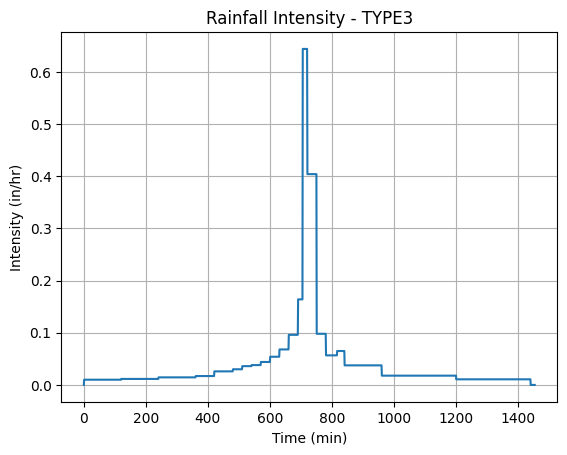

In [4]:
# Python port of FORTRAN program to interpolate rain/runoff data to 1-minute intervals

def interpolate_rainfall(input_lines):
    etime = []
    acc_wtd_value = []

    # Read and parse data
    for line in input_lines:
        line = line.strip()
        if line.startswith("#") or len(line.strip()) == 0:
            continue
        parts = line.split()
        if len(parts) == 2:
            etime.append(float(parts[0]))
            acc_wtd_value.append(float(parts[1]))

    # Round time to nearest whole minute
    for i in range(1, len(etime)): 
        etime[i]=round((etime[i])*60.0,0) # round to nearest whole number as float

    # Interpolate values
    interpolated = []
    for i in range(1, len(etime)):
        t0, t1 = etime[i - 1], etime[i]
        v0, v1 = acc_wtd_value[i - 1], acc_wtd_value[i]
#        print(t0,t1,v0,v1)
        slope = (v1 - v0) / (t1 - t0)

        rtime = t0
        while rtime < t1:
            value = v0 + slope * (rtime - t0)
            interpolated.append((round(rtime, 6), round(value, 6)))
            rtime += 1.0

    return interpolated


if __name__ == "__main__":
    # Example input: could be replaced with reading from a file
    sample_data = """# Time Depth
0.0 0.0
2.0 0.022
4.0 0.048
6.0 0.08
7.0 0.098
8.0 0.12
8.5 0.133
9.0 0.147
9.5 0.163
9.75 0.172
10.0 0.181
10.5 0.204
11.0 0.235
11.5 0.283
11.75 0.357
12.0 0.663
12.5 0.735
13.6 0.772
13.5 0.799
14.0 0.82
16.0 0.88
20.0 0.952
24.0 1.0
24.5 1.0
"""
# Remember to pad the data so last line is one minute more that actual last line of data

    lines = sample_data.strip().split("\n")

    print(lines)
    
    results = interpolate_rainfall(lines)

    import pandas as pd
    n = 15
    df = pd.DataFrame(results, columns=["Time (min)", "Interpolated Value"])
    df_thinned = df.iloc[::n]  # selects every n-th row starting from 0
    df_thinned.to_csv("interpolated_output_TypeII_thinned.csv", index=False)
    print("Saved interpolated data to interpolated_output.csv")
    print(df_thinned)

['# Time Depth', '0.0 0.0', '2.0 0.022', '4.0 0.048', '6.0 0.08', '7.0 0.098', '8.0 0.12', '8.5 0.133', '9.0 0.147', '9.5 0.163', '9.75 0.172', '10.0 0.181', '10.5 0.204', '11.0 0.235', '11.5 0.283', '11.75 0.357', '12.0 0.663', '12.5 0.735', '13.6 0.772', '13.5 0.799', '14.0 0.82', '16.0 0.88', '20.0 0.952', '24.0 1.0', '24.5 1.0']
Saved interpolated data to interpolated_output.csv
      Time (min)  Interpolated Value
0            0.0             0.00000
15          15.0             0.00275
30          30.0             0.00550
45          45.0             0.00825
60          60.0             0.01100
...          ...                 ...
1410      1404.0             0.99280
1425      1419.0             0.99580
1440      1434.0             0.99880
1455      1449.0             1.00000
1470      1464.0             1.00000

[99 rows x 2 columns]
